<a href="https://colab.research.google.com/github/aliciafmachado/texture_singan/blob/main/SinGAN_Alicia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthesis of textures from generative adversarial networks (SinGAN)

Authors: Alicia FORTES MACHADO et Raphael MENDES

## Introduction

The key innovation on [SinGAN: Learning a Generative Model from a Single Natural Image](https://arxiv.org/pdf/1905.01164.pdf)  is to train from a single image and generalize a GAN to different tasks in computer vision: denoising, inpainting, generation of new images from random noise, and even animation.

[expliquer un peu des autres choses qui sont là aujourdhui]



## Theory

[expliquer comment singan fonctionne et tout]

## Training of the neural network SinGAN

If you want to go straight to the results, please jump the part of loading and training models and go straight to qualitative results. Then we analyze a metric: SIFID, which adapts FID to single image usage.

### Setting up

Connecting to drive if you are using colab:

In [1]:
# Connect to drive in to save images and etc directly there
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd 'drive/My Drive/MVA/ImagerieNumerique/projet'
%ls

Mounted at /content/drive
/content/drive/My Drive/MVA/ImagerieNumerique/projet
SinGAN/


Use cells below only if it's first installation.



In [ ]:
## First we clone SinGAN if necessary:
# ! git clone https://github.com/tamarott/SinGAN.git

In [2]:
% cd SinGAN

/content/drive/My Drive/MVA/ImagerieNumerique/projet/SinGAN


In [3]:
! python -m pip install -r requirements.txt

In [4]:
# Downgrade torchvision version
! pip install --upgrade torchvision==0.4.0

## Auxiliary Functions

Some auxiliary functions to deal with images and change them as we need.

They were used to transform the original images in the size that we want. There is an other function that convert images from png to jpg, so that we can apply SIFID on them. An other function is the one that crops the image in the center so that we can test the capacity of SinGAN to produce texture from less data.

In [7]:
from PIL import Image

def resize(img_path, save_path, h=600, v=None):
  im = Image.open(img_path)
  h_or, v_or = im.size
  im_r = im.resize((h, int(v_or * h / h_or)))
  im_r.save(save_path)
  print('Saved image!')

In [8]:
def convert_to_jpg(filename, path, move_to_results=False, move_to_comp=False):
  im = Image.open(path + '/' + filename + '.png')
  rgb_im = im.convert('RGB')
  if move_to_results:
    rgb_im.save('Input/Results/' + filename + '.jpg')
  elif move_to_comp:
    rgb_im.save('Input/Comparison/' + filename + '.jpg')
  else:
    rgb_im.save(path + '/' + filename + '.jpg')

In [9]:
def crop_img(img_path, save_path, size=0.5):
  "Crops from middle."
  im = Image.open(img_path)
  h_or, v_or = im.size
  top = v_or * (1 - size) / 2
  bottom = v_or * (1 + size) / 2
  left = h_or * (1 - size) / 2
  right = h_or * (1 + size) / 2
  im_c = im.crop((left, top, right, bottom))
  im_c.save(save_path)
  print('Cropped image!')

In order to run patchmatch, you have to run the file pm_minimal.cpp, which is a slightly modified version (only on the part of saving the output) of the official minimal implementation of patchmatch (therefore, not totally optimized).

In [ ]:
# This is how you can run the file "pm_minimal.cpp" in the zipped folder:
# If you want to compile from scratch
! g++ pm_minimal.py
# If you want to run the executable directly
# TODO: change code so that saving bitmaps is optional
! a.out fake_image.png real_image.png unnecessary_arg.png unnecessary_arg.png

Now, some auxiliary functions for reading and treating the data saved by patchmatch:

In [36]:
def read_patchmatch_out(path, file):
  """
  Read patchmatch output file.
  """
  with open(path, 'r') as f:
    lines = f.read().splitlines()
  l = [[int(num) for num in line.split(" ") if num] for line in lines]
  matrix = np.array(l)

  if file == 'ann':
    shp = matrix.shape
    matrix = matrix.reshape(shp[0], shp[1] // 2, 2)

  return matrix

def get_patchmatch_info(ann_pth, annd_pth):
  """
  We read the pacthmatch and returns a matrix with the mapping to
  the original image patches, and the distances matrix.
  """
  ann = read_patchmatch_out(ann_pth, file='ann')
  annd = read_patchmatch_out(annd_pth, file='annd')

  return ann, annd

We test it on some data.

TODO: delete this

In [37]:
ann_pth = 'ann.txt'
annd_pth = 'annd.txt'
ann, annd = get_patchmatch_info(ann_pth, annd_pth)

In [53]:
# Test if everything is working properly:
from PIL import Image

img_or = Image.open('a.png')
img_other = Image.open('b.png')
img_or_arr = np.array(img_or)
img_other_arr = np.array(img_other)

In [66]:
# There is a mapping from A -> B
# Thus, if we want to analyze the mapping from the fake image
# we have to first pass the fake image as first argument
# and then pass the original image as second argument
patch_or = img_or_arr[0:0+7, 0:0+7, :]
patch_other = img_other_arr[18:(18+7), 398:(398+7), :]

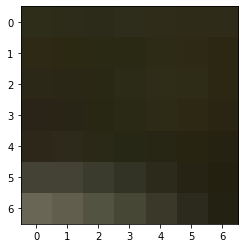

In [70]:
from matplotlib import pyplot as plt

plt.imshow(patch_or)
plt.show()

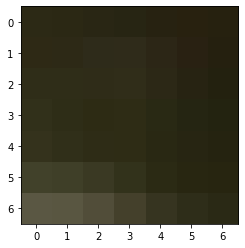

In [71]:
plt.imshow(patch_other)
plt.show()

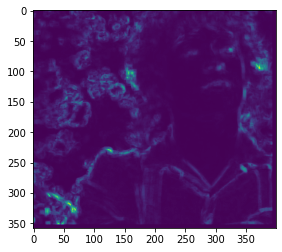

In [75]:
plt.imshow(annd)
plt.show()

## Load trained models and test them

In [5]:
%%time
! python random_samples.py --input_name rocks_small_1_8.png --mode random_samples_arbitrary_sizes --gen_start_scale 0 --scale_h 8 --scale_v 8
! python random_samples.py --input_name rocks_small_1_8.png --mode random_samples_arbitrary_sizes --gen_start_scale 0 --scale_h 4 --scale_v 4
! python random_samples.py --input_name rocks_small_1_8.png --mode random_samples_arbitrary_sizes --gen_start_scale 0 --scale_h 2 --scale_v 2
! python random_samples.py --input_name rocks_small_1_8.png --mode random_samples_arbitrary_sizes --gen_start_scale 0 --scale_h 1 --scale_v 1

Random Seed:  3133
Random Seed:  2079
Random Seed:  4853
Random Seed:  5138
CPU times: user 683 ms, sys: 109 ms, total: 793 ms
Wall time: 1min 53s


In [24]:
! python random_samples.py --input_name saumon.png --mode random_samples_arbitrary_sizes --gen_start_scale 0 --scale_h 4 --scale_v 1

Random Seed:  4504


In [25]:
! python random_samples.py --input_name saumon.png --mode random_samples_arbitrary_sizes --gen_start_scale 0 --scale_h 1 --scale_v 4

Random Seed:  9949


In [ ]:
from google.colab import files
# Download Output
! zip -r Output_smaller_rocks_leafs_saumon Output
files.download('Output_smaller_rocks_leafs_saumon.zip')

Here, we can argue that there it has a high complexity with respect to the size of the final image, since it took 3min28s for 8 times the original size of the rocks image. While for 4 it took 52s.

Results are qualitatively comparable to samples generated from larger rocks image.

In terms of metrics, we measure those below.

Training time was similar, which suggests that maybe it trains as much in a smaller image, and therefore improve results. We will try with a larger images and analyze results

In [ ]:
! python paint2image.py --input_name rock_small_cropped.png --ref_name cows.png --paint_start_scale 4

Random Seed:  8663


In [ ]:
! zip -r Output.zip Output

In [27]:
from google.colab import files
files.download('Output.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Training new models

This section is in case you want to train the models yourself, which may take a while.

We advise you to run the code on GPU, although it's possible to run on CPU. If running on CPU, you will need to add an extra flag '--not_cuda'.

In [ ]:
from config import get_arguments
from SinGAN.manipulate import *
from SinGAN.training import *
import SinGAN.functions as functions

# We use the code from main_train.py but create a function to make the 
# experiemnts easier to run
def main_train(input_name, input_dir='Input/Images', mode='train'):
  opt = 
  Gs = []
  Zs = []
  reals = []
  NoiseAmp = []
  dir2save = functions.generate_dir2save(opt)
  if (os.path.exists(dir2save)):
      print('trained model already exist')
  else:
      try:
          os.makedirs(dir2save)
      except OSError:
          pass
      real = functions.read_image(opt)
      functions.adjust_scales2image(real, opt)
      train(opt, Gs, Zs, reals, NoiseAmp)
      SinGAN_generate(Gs,Zs,reals,NoiseAmp,opt)

In [ ]:
%%time
! python main_train.py --input_name bricks.png

In [ ]:
%%time
! python main_train.py --input_name bricks_0_5.png

In [26]:
%%time
! python main_train.py --input_name rocks_new.png

Random Seed:  1774
GeneratorConcatSkip2CleanAdd(
  (head): ConvBlock(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (body): Sequential(
    (block1): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (block2): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (block3): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [27]:
! python main_train.py --input_name starry_night.png

Random Seed:  8650
GeneratorConcatSkip2CleanAdd(
  (head): ConvBlock(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (body): Sequential(
    (block1): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (block2): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (block3): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [ ]:
%%time
! python main_train.py --input_name leafs_small_cropped.png

In [ ]:
%%time
! python main_train.py --input_name saumon.png

In [ ]:
%%time
! python main_train.py --input_name leafs_small_1_8.png

In [ ]:
# Can our nn build a wall of bricks? and keep structural things
# TODO

In [ ]:
# Download models
! zip -r TrainedModels_smaller_text.zip TrainedModels
files.download('TrainedModels_smaller_text.zip')

In [ ]:
## On fait des testes
! python random_samples.py --input_name rocks_small.png --mode random_samples --gen_start_scale 0

Random Seed:  6142


## Calculate metrics

We need to convert to JPG so that SIFID works.

In [16]:
! rm Input/Results/rocks_small_1_8.jpg

In [16]:
filename = 'rocks_small_1_8'
path = "Input/Images"
convert_to_jpg(filename, path, move_to_results=True)

In [17]:
filename = '0'
path = 'Output/RandomSamples_ArbitrerySizes/rocks_small_1_8/scale_v=4.000000_scale_h=4.000000'
convert_to_jpg(filename, path)

In [ ]:
# Remove so that we calculate the SIFID for correct image
! rm Output/RandomSamples_ArbitrerySizes/rocks_small_1_8/scale_v=1.000000_scale_h=1.000000/0.jpg

The path is to the folder and not the file.



In [48]:
%%time
# CAUTION: coment lines 245 and 246 in sifid_score.py to work
# Before running this cell, it's necessary to coment lines 245 and 246 in the code
# Since it requires the last characters of the image to be an integer number
! python SIFID/sifid_score.py --path2real Input/Results --path2fake Output/RandomSamples_ArbitrerySizes/rocks_small_1_8/scale_v\=4.000000_scale_h\=4.000000

  0% 0/1 [00:00<?, ?it/s](3456, 64)
100% 1/1 [00:00<00:00, 65.56it/s]
[0.38643265 0.12588269 0.5168602  0.         0.19210917 1.0132062
 0.03733481 0.2187558  0.16756393 1.595552   0.7283322  1.3132784
 0.2581503  2.1356332  0.3459977  0.41647297 0.39641932 0.43195778
 0.1267359  0.13668343 1.73003    3.2349567  0.2326821  0.2907718
 0.8468198  0.30279994 0.61838394 0.7379306  0.6312141  0.5603101
 0.4875922  2.180766   1.2895669  0.5396696  0.46225876 0.30288938
 1.4889758  0.9200349  0.2942467  0.6536601  0.44650766 0.39448375
 0.49137184 0.2546058  0.5321687  1.8513262  0.27459684 0.1842735
 0.         1.5179836  0.26098102 0.38559547 0.12476847 0.30259153
 0.03081856 0.4795569  0.2606905  0.3334667  0.26939437 1.54691
 0.58630157 0.4829745  1.6154069  0.31723064] [[ 0.37284477  0.02187    -0.0247867  ... -0.14201146 -0.06492087
  -0.09180358]
 [ 0.02187     0.2984669   0.0986153  ... -0.00626569  0.07561202
   0.01137355]
 [-0.0247867   0.0986153   0.11031934 ...  0.03112687  0.039

This results is correspondent to the ones reported in the paper. Now let's check for larger outputs.

Then, we compare the 4 times increased to the original image.

In [18]:
%%time
# Evaluate when we want to increase the size of the image 4 times
# horizontally and vertically
! python SIFID/sifid_score.py --path2real Input/Results --path2fake Output/RandomSamples_ArbitrerySizes/rocks_small_1_8/scale_v\=4.000000_scale_h\=4.000000

100% 1/1 [00:00<00:00, 82.29it/s]
100% 1/1 [00:00<00:00,  8.48it/s]
SIFID:  0.74693894
CPU times: user 1 s, sys: 145 ms, total: 1.15 s
Wall time: 3min 41s


In [19]:
! rm Input/Results/rocks_small_1_8.jpg
convert_to_jpg('rocks_small', 'Input/Images', move_to_results=True)

In [20]:
%%time
# Evaluate with respect to original image
! python SIFID/sifid_score.py --path2real Input/Results --path2fake Output/RandomSamples_ArbitrerySizes/rocks_small_1_8/scale_v\=4.000000_scale_h\=4.000000

100% 1/1 [00:00<00:00, 11.92it/s]
100% 1/1 [00:00<00:00,  9.40it/s]
SIFID:  0.2079012
CPU times: user 919 ms, sys: 133 ms, total: 1.05 s
Wall time: 3min 29s


In [22]:
convert_to_jpg('rocks_small_1_8', 'Input/Images', move_to_comp=True)

In [23]:
%%time
# Evaluate patch removed from original image w.r.t. to the one created
! python SIFID/sifid_score.py --path2real Input/Results --path2fake Input/Comparison

100% 1/1 [00:00<00:00, 11.77it/s]
100% 1/1 [00:00<00:00, 103.49it/s]
SIFID:  0.64149064
CPU times: user 926 ms, sys: 131 ms, total: 1.06 s
Wall time: 3min 33s


In [ ]:
# Analyze statistics: distribution...
# TODO: choose statistics and write here
# TODO: implement statistics

In [ ]:
# Transfer learning idea
# Load the model and call training on top of it
# TODO

let'do it!


In [ ]:
! zip -r TrainedModels_w_smaller_rock.zip TrainedModels
# ! zip -r Output_smaller.zip Output
from google.colab import files
files.download('TrainedModels_w_smaller_rock.zip')
# files.download('Output_rock.zip')

In [ ]:
! python main_train.py --input_name leafs_small.png

In [ ]:
! zip -r TrainedModels_leafs.zip TrainedModels
from google.colab import files
files.download('TrainedModels_leafs.zip')

## Qualitative Results

We test on different textures that have particular structures and show how the neural networks performs badly / well.

We will focus on the trying different approaches in terms of size of the image and changing the convolution kernel for the rocks image.

### Rocks texture

Original image:

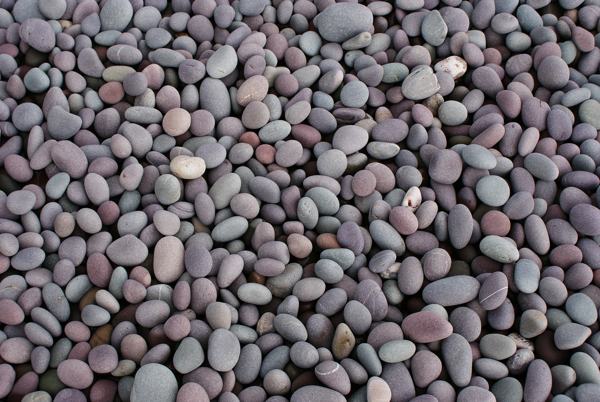

Results when using original image:

We also tried to crop one quarter of the original image and produce results in a larger size, to see if we could reproduce the same texture but using less data, and therefore taking less time to train:

Now, for $\frac{1}{16}$ of the original image:

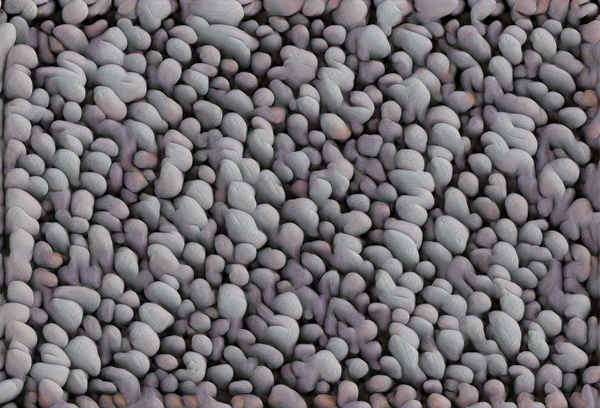

Results show that the algorithm is capable to generalize, but as we decrease the size of the image, we have worse results. This is probably due to the fact that the model has less data to train (less patches). One idea then was to reduce the number of trainable parameters by reducing the size of the convolution. This way, we would force the neural network to learn what is essential to the image. We try this approach for one quarter of the original image:

TODO

### Saumon texture

First, we show the original image:

When expanding the saumon texture in the horizontal, we can see that the stripes are almost correctly expanded on the horizontal, and that there are very few stripes that are broken in the middle or that bifurcate.

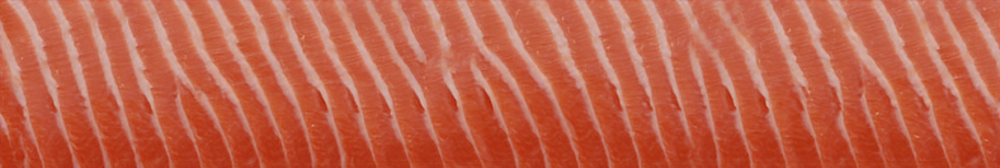

However, when expanding it on the vertical, we can see more inconsistencies than when extending horizontally.

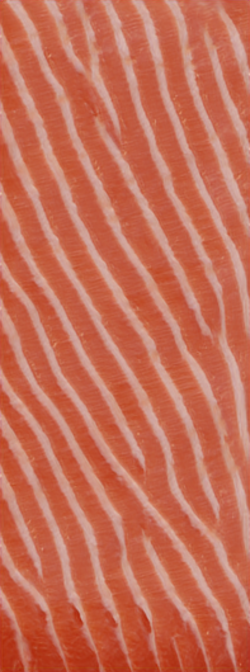

### Bricks texture

### Leafs texture

## Metrics

On a décidé de faire une analyse quantitative des échantillons générés.

In [63]:
# Here we implement the auxiliary function to create the patches and save
# them into a folder
import numpy as np
from skimage.util.shape import view_as_windows
from PIL import Image

def save_patches(img_pth, img_name, save_pth, patch_div, 
                 method='naive'):
  # First, we take the patches
  # Read images
  # TODO: remove files from Results when running this
  # TODO: remove files from Comparison automatically as well
  # TODO: modify sifid_score.py in the import and in the lines cited below
  # so that we don't have to do it everytime (import in line 41 becomes 
  # from SIFID.inception)
  print('Beginning creation of patches')
  img = Image.open(img_pth)
  img_np = np.array(img)
  h, v = img.size
  window_shape = (v // patch_div, h // patch_div, 3)

  img_patches = view_as_windows(img_np, window_shape)
  for i in range(patch_div):
    for j in range(patch_div):
      img_patch = Image.fromarray(img_patches[i * window_shape[0],
                                               j * window_shape[1],
                                               0])
      img_patch.save(save_pth + '/'+ img_name + 
                     '_patch_' + str(i) + '_' + str(j) + '.jpg')
  print('Finished!')
  

save_patches(img_pth='Output/RandomSamples_ArbitrerySizes/rocks_small_1_8/scale_v=4.000000_scale_h=4.000000/0.jpg', 
             img_name='rocks_small_1_8_scale_v=4.000000_scale_h=4.000000_0.jpg',
             save_pth='Input/Results',
             patch_div=4)


Beginning creation of patches
Finished!


In [64]:
from SIFID.sifid_score import *
from SIFID.inception import InceptionV3


def calculate_sifid_given_paths_mult(path1, path2, batch_size, cuda, dims,
                                    suffix, mult_patch_approach):
  """Calculates the SIFID of two paths"""

  block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

  model = InceptionV3([block_idx])
  if cuda:
      model.cuda()

  path1 = pathlib.Path(path1)
  files1 = list(path1.glob('*.%s' %suffix))

  path2 = pathlib.Path(path2)
  files2 = list(path2.glob('*.%s' %suffix))

  # If we use the naive approach, then we repeat the file
  # for the number of patches saved in the folder
  if mult_patch_approach == 'naive':
    files1 = len(files2) * files1

  fid_values = []
  Im_ind = []

  for i in range(len(files2)):
      m1, s1 = calculate_activation_statistics([files1[i]], model, batch_size, dims, cuda)
      print(m1, s1)
      m2, s2 = calculate_activation_statistics([files2[i]], model, batch_size, dims, cuda)
      print(m2, s2)
      fid_values.append(calculate_frechet_distance(m1, s1, m2, s2))
      file_num1 = files1[i].name
      file_num2 = files2[i].name

  return fid_values


# We reiplement SIFID here so that we take the mean between
# the patches on the image created
def main_sifid_multiple_patches(path2real, path2fake, suffix, gpu, 
                                mult_patch_approach= 'naive'):
  """
  We save the patches and then use them, which might not be
  very efficient but works properly.
  """
  sifid_values = calculate_sifid_given_paths_mult(path2real, path2fake, 
                                                  1, gpu,
                                                  64, suffix, 
                                                  mult_patch_approach)
  sifid_values = np.asarray(sifid_values,dtype=np.float32)
  np.save('SIFID', sifid_values)
  print('SIFID: ', sifid_values.mean())
  return sifid_values


In [ ]:
sifid_values = main_sifid_multiple_patches(path2real='Input/Comparison',
                                           path2fake='Input/Results',
                                           suffix='jpg',
                                           gpu=True,
                                           mult_patch_approach='naive')

0.28377065


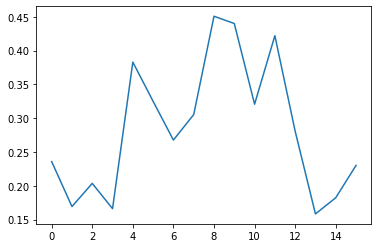

0.09665579


In [70]:
print(np.mean(sifid_values))
 
from matplotlib import pyplot as plt

plt.plot(sifid_values)
plt.show()

print(np.std(sifid_values))

## Patchmatch and SinGAN

On propose ici une analyse du méthode proprosée à l'article SinGAN en utilisant Patchmatch, de façon à vérifier le méthode.

Le méthode consiste en prendre des patches plus proches des ces qu'on analyse sur l'image produit. De cette façon on peut compare ces patches de l'image généré avec l'image original en utilisant SIFID et en prenant le moyenne à la fin (entre tous les patches de l'image généré).

In [ ]:
# Pour patch-match: comparer les résultats
# Implementation of nearest neighbor
def get_nn_patch():
  pass

In [ ]:
# On calcule les métriques en utilisant get_nn_patch
def get_metric_on_large_image():
  pass

## Transfer Learning

According to [Transferring GANs: generating images from
limited data](https://openaccess.thecvf.com/content_ECCV_2018/papers/yaxing_wang_Transferring_GANs_generating_ECCV_2018_paper.pdf), it's possible to do transfer learning on GANs, and therefore we do a try, in order to make learning faster for a new image considering that we have a trained neural network on a similar image.

We decided to focus on a single pair of images: the original rocks and a new image of rocks, and we want to generate a new image of rocks using less ressources, since it takes very long to train on a single image.

If you want to run this part, you will need to replace the certain files in the folder of SinGAN by the modified files for transfer learning on the zipped file extra.zip .

In [ ]:
# First we try to start by using an already trained nn as initial weights and
# not freeze any generators / discriminators


In [ ]:
# Now we try to freeze some layers and see how it goes
# TODO

In [71]:
! gcc --version

gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [4]:
! ls

animation.py	  imgs		  pm_minimal.cpp     SIFID.npy
config.py	  Input		  __pycache__	     SinGAN
config.pyc	  LICENSE.txt	  random_samples.py  SR.py
Downloads	  main_train.py   README.md	     TrainedModels
editing.py	  Output	  requirements.txt
harmonization.py  paint2image.py  SIFID


In [7]:
! g++ pm_minimal.cpp

## Robustness

In [ ]:
# Varying number of layers for same input
# 3, 4, 5, 6, 7
# Testing with this would require to change the code to save with a different name
# %%time
# ! python main_train.py --input_name rocks_small.png --num_layer 3
# ! python main_train.py --input_name rocks_small.png --num_layer 4
# ! python main_train.py --input_name rocks_small.png --num_layer 6

In [10]:
# Varying scale factor
# 0.60, 0.70, 0.75, 0.80, 0.90
%%time
! python main_train.py --input_name rocks_small.png --scale_factor 0.60
! python main_train.py --input_name rocks_small.png --scale_factor 0.70
! python main_train.py --input_name rocks_small.png --scale_factor 0.80
! python main_train.py --input_name rocks_small.png --scale_factor 0.90

A saída de streaming foi truncada nas últimas 5000 linhas.
scale 0:[1075/2000]
scale 0:[1100/2000]
scale 0:[1125/2000]
scale 0:[1150/2000]
scale 0:[1175/2000]
scale 0:[1200/2000]
scale 0:[1225/2000]
scale 0:[1250/2000]
scale 0:[1275/2000]
scale 0:[1300/2000]
scale 0:[1325/2000]
scale 0:[1350/2000]
scale 0:[1375/2000]
scale 0:[1400/2000]
scale 0:[1425/2000]
scale 0:[1450/2000]
scale 0:[1475/2000]
scale 0:[1500/2000]
scale 0:[1525/2000]
scale 0:[1550/2000]
scale 0:[1575/2000]
scale 0:[1600/2000]
scale 0:[1625/2000]
scale 0:[1650/2000]
scale 0:[1675/2000]
scale 0:[1700/2000]
scale 0:[1725/2000]
scale 0:[1750/2000]
scale 0:[1775/2000]
scale 0:[1800/2000]
scale 0:[1825/2000]
scale 0:[1850/2000]
scale 0:[1875/2000]
scale 0:[1900/2000]
scale 0:[1925/2000]
scale 0:[1950/2000]
scale 0:[1975/2000]
scale 0:[1999/2000]
GeneratorConcatSkip2CleanAdd(
  (head): ConvBlock(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, tra

In [11]:
# Varying alpha
! python main_train.py --input_name rocks_small.png --alpha 8
! python main_train.py --input_name rocks_small.png --alpha 12

Random Seed:  3674
GeneratorConcatSkip2CleanAdd(
  (head): ConvBlock(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (body): Sequential(
    (block1): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (block2): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (block3): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   